# Определение перспективного тарифа для телеком компании

**Цель исследования:**
Компания «Мегалайн» — федеральный оператор сотовой связи- предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, нужно выяснить, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов.  Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Исходные данные:** 

Данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

**Задачи:** 

- Обработка дубликатов, пропусков, ошибок в данных.
- Объединение таблиц.
- Расчет помесячной выручки.
- Анализ использования тарифов и показателей выручки.
- Проведение статистических тестов на равенство средней выручки.

## Обзор данных

### Описание тарифов

***Тариф «Смарт»***
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

***Тариф «Ультра»***
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

### Описание данных

***Таблица users (информация о пользователях):***

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

***Таблица calls (информация о звонках):***

* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

***Таблица messages (информация о сообщениях):***

* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

***Таблица internet (информация об интернет-сессиях):***

* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

***Таблица tariffs (информация о тарифах):***

* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
%%javascript #отключить автоматическую прокрутку
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#установка и импорт библотек
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore') #отключить предупреждения
pd.set_option('display.max_colwidth', -1) #задать максимальную ширину столбцов

In [3]:
def display_datainfo(path, sep):
    """функция для вывода датасета, описания, подсчета значений в столбцах
    
    принимает на вход путь к файлу path и разделитель sep"""
    
    try:
        df = pd.read_csv(path, sep)
    except:
        df = pd.read_csv('/datasets/'+path, sep)
    print('\033[1m'+'Первые 5 строк данных'+'\033[0m')
    display(df.head())
    print('_'*50)
    print('\033[1m'+"Типы и размер данных"+'\033[0m')
    display(df.info())
    print('_'*50)
    print('\033[1m'+"Статистика"+'\033[0m')
    display(df.describe())
    print('_'*50)
    print('\033[1m'+ 'Всего пропусков:'+'\033[0m')
    display(df.isna().sum())
    print('_'*50)
    print('\033[1m'+f'Полные дубликаты:{df.duplicated().sum()}'+'\033[0m')
    print('_'*50)
    print('\033[1m'+'Значения столбцов:'+'\033[0m')
    print(' ')
    for col in df.columns:
        print('\033[1m'+str(col)+'\033[0m')
        print(df[col].value_counts())
        print('_'*50)
        print('')
    return df

### Таблица "Звонки"

In [4]:
#вывод на экран части таблицы и её описание
calls = display_datainfo('calls.csv', sep=',')

Первые 5 строк данных


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


__________________________________________________
Типы и размер данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

__________________________________________________
Статистика


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


__________________________________________________
Всего пропусков:


id           0
call_date    0
duration     0
user_id      0
dtype: int64

__________________________________________________
Полные дубликаты:0
__________________________________________________
Значения столбцов:
 
id
1000_0      1
1344_881    1
1344_883    1
1344_884    1
1344_885    1
           ..
1171_562    1
1171_563    1
1171_564    1
1171_565    1
1499_219    1
Name: id, Length: 202607, dtype: int64
__________________________________________________

call_date
2018-12-31    1435
2018-12-29    1202
2018-12-30    1192
2018-12-22    1158
2018-12-26    1149
              ... 
2018-01-05    20  
2018-01-07    18  
2018-01-02    9   
2018-01-03    7   
2018-01-01    5   
Name: call_date, Length: 365, dtype: int64
__________________________________________________

duration
0.00     39613
4.49     142  
5.50     142  
6.15     141  
6.38     141  
        ...   
26.94    1    
32.19    1    
26.32    1    
27.41    1    
26.90    1    
Name: duration, Length: 2871, dtype: int64
__________________________________________________

user_id
1377    1760
1168  

### Таблица "Интернет"

In [5]:
#вывод на экран части таблицы и её описание
internet = display_datainfo('internet.csv', sep=',')

Первые 5 строк данных


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


__________________________________________________
Типы и размер данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

__________________________________________________
Статистика


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


__________________________________________________
Всего пропусков:


Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

__________________________________________________
Полные дубликаты:0
__________________________________________________
Значения столбцов:
 
Unnamed: 0
0         1
99574     1
99594     1
99595     1
99596     1
         ..
49798     1
49799     1
49800     1
49801     1
149395    1
Name: Unnamed: 0, Length: 149396, dtype: int64
__________________________________________________

id
1000_0      1
1333_109    1
1334_0      1
1334_1      1
1334_2      1
           ..
1172_80     1
1172_81     1
1172_82     1
1172_83     1
1499_156    1
Name: id, Length: 149396, dtype: int64
__________________________________________________

mb_used
0.00      19598
335.91    9    
447.30    9    
197.56    9    
199.11    8    
         ..    
643.43    1    
973.04    1    
834.51    1    
777.30    1    
23.72     1    
Name: mb_used, Length: 70003, dtype: int64
__________________________________________________

session_date
2018-12-31    1057
2018-12-30    903 
2018-12-25    859 
2018-12-26    844 


### Таблица "Сообщения"

In [6]:
#вывод на экран части таблицы и её описание
messages = display_datainfo('messages.csv', sep=',')

Первые 5 строк данных


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


__________________________________________________
Типы и размер данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

__________________________________________________
Статистика


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


__________________________________________________
Всего пропусков:


id              0
message_date    0
user_id         0
dtype: int64

__________________________________________________
Полные дубликаты:0
__________________________________________________
Значения столбцов:
 
id
1000_0      1
1344_248    1
1344_96     1
1344_95     1
1344_94     1
           ..
1174_352    1
1174_351    1
1174_350    1
1174_349    1
1499_183    1
Name: id, Length: 123036, dtype: int64
__________________________________________________

message_date
2018-12-31    859
2018-12-30    765
2018-12-21    712
2018-12-29    702
2018-12-28    699
             ... 
2018-01-11    12 
2018-01-05    10 
2018-01-04    10 
2018-01-02    10 
2018-01-03    4  
Name: message_date, Length: 364, dtype: int64
__________________________________________________

user_id
1277    1463
1089    1408
1231    1384
1385    1380
1356    1224
        ... 
1389    6   
1279    5   
1074    3   
1159    2   
1141    1   
Name: user_id, Length: 426, dtype: int64
__________________________________________________



### Таблица "Тарифы"

In [7]:
#вывод на экран части таблицы и её описание
tariffs = display_datainfo('tariffs.csv', sep=',')

Первые 5 строк данных


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


__________________________________________________
Типы и размер данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

__________________________________________________
Статистика


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


__________________________________________________
Всего пропусков:


messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

__________________________________________________
Полные дубликаты:0
__________________________________________________
Значения столбцов:
 
messages_included
50      1
1000    1
Name: messages_included, dtype: int64
__________________________________________________

mb_per_month_included
15360    1
30720    1
Name: mb_per_month_included, dtype: int64
__________________________________________________

minutes_included
500     1
3000    1
Name: minutes_included, dtype: int64
__________________________________________________

rub_monthly_fee
550     1
1950    1
Name: rub_monthly_fee, dtype: int64
__________________________________________________

rub_per_gb
200    1
150    1
Name: rub_per_gb, dtype: int64
__________________________________________________

rub_per_message
3    1
1    1
Name: rub_per_message, dtype: int64
__________________________________________________

rub_per_minute
3    1
1    1
Name: rub_per_minute, dtype: int64
________________________________________________

### Таблица "Пользователи"

In [8]:
#вывод на экран части таблицы и её описание
users = display_datainfo('users.csv', sep=',')

Первые 5 строк данных


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


__________________________________________________
Типы и размер данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

__________________________________________________
Статистика


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


__________________________________________________
Всего пропусков:


user_id       0  
age           0  
churn_date    462
city          0  
first_name    0  
last_name     0  
reg_date      0  
tariff        0  
dtype: int64

__________________________________________________
Полные дубликаты:0
__________________________________________________
Значения столбцов:
 
user_id
1000    1
1329    1
1342    1
1341    1
1340    1
       ..
1161    1
1160    1
1159    1
1158    1
1499    1
Name: user_id, Length: 500, dtype: int64
__________________________________________________

age
53    14
42    14
63    13
64    13
71    13
73    12
21    12
40    12
37    11
29    11
39    11
26    11
47    11
70    10
45    10
41    10
52    10
58    10
36    10
66    9 
23    9 
50    9 
65    9 
19    9 
48    9 
24    9 
68    9 
27    9 
28    9 
51    9 
20    9 
56    9 
30    9 
60    8 
44    8 
69    8 
62    8 
55    8 
74    7 
25    7 
46    7 
35    7 
32    7 
67    7 
43    7 
31    7 
18    6 
75    6 
54    6 
59    6 
72    5 
22    5 
34    5 
33    5 
38    5 
49    4 
57    4 
61    3 
Name: age, dtype: int64
__________________________________________________

churn_date
2018-12-03    2
2018-10-03    2
20

In [9]:
print('Все пользователи подключили тарифы в течение периода:', users['reg_date'].min(),'-', users['reg_date'].max())

Все пользователи подключили тарифы в течение периода: 2018-01-01 - 2018-12-31


### Вывод

В ходе первичного обзора данных обратили внимание на следующие особенности:

1. Таблица `calls` содержит информацию о времени и продолжительности всех звонков выбранных абонентов за 2018 год. В таблице 202607 строк и 4 столбца. Названия столбцов заданы корректно. Пропусков в структуре данных нет. 
2. В столбце `duration` 39613 нулевых значения - почти 20% от общего числа звонков. Нули могут быть пропущенными вызовами. Необходимо исследовать чувствительность результатов исследования к наличию или отстутсвию таких значений в датасете. 
3. Таблица `internet` содержит информацию о времени и объеме всех интернет-сессий абонентов за период. В таблице 149396 и 5 столбцов. Названия столбцов заданы корректно.Столбец `Unnamed: 0` дублирует индексы. Вероятно, он появился из-за неправильной выгрузке данных. От него можно избавиться. Пропусков в структуре данных нет. 
4. В столбце `mb_used` 19598 нулевых значения - 13% от общего числа сессий. Это могут быть мнгновенные подключения со стороны пользователя или тестовые запуски приложений с объемом трафика до 10 Кб. Необходимо исследовать чувствительность результатов исследования к наличию или отстутсвию таких значений в датасете.
5. Таблица `messages` содержит информацию о времени отправки всех смс-сообщений абонентов за период. В таблице 123036 строк и 3 столбца. Названия столбцов заданы корректно. Пропусков в структуре данных нет.
6. Таблица `tariffs` содержит параметры тарифных планов. В таблице 2 строки и 8 столбцов. Названия столбцов заданы корректно. Пропусков в структуре данных нет. Типы данных для числовых значений заданы оптимально - int64. 
7. Таблица `users` содержит информацию о пользователях: имя, фамилия, возраст, город, тариф, дата подключения и выхода из тарифа. В таблице 500 строк и 8 столбцов. Названия столбцов заданы корректно.
8. В столбце `churn_date`  есть пропуски и только 38 значений из 500 заполнены. Более 7% пользователей сменили тариф в течение года.
9. Все пользователи в таблице подключили тарифы в 2018 году.
10. Данные в столбцах: `call_date`,`session_date`, `churn_date`, `reg_date`, `message_date` хранятся в формате float. Целесообразно изменить тип данных на datetime.  
11. Тип данных столбцов: `user_id`- int64. Данные можно хранить в типе данных int32, т.о. файл будет занимать меньше места на диске.
12. Данные необходимо проверить на дубликаты, ошибки, выбросы.
13. Для исследования предоставлены данные по 500 абонентам, пользующимся исследуемыми тарифами "Смарт" и "Ультра" за 2018 год.
14. Пользователей тарифа "Смарт" в выборке - 351 - в 2,35 раза больше, чем пользователей тарифа "Ультра" - 149.

## Предобработка данных

### Обработка дубликатов

Дубликаты не обнаружены.

Столбец `Unnamed: 0` в таблице `internet` дублирует индексы. Отбросим его.

In [10]:
internet = internet[['id','user_id','session_date','mb_used']]
internet.head(2) #Проверим результат преобразования

,id,user_id,session_date,mb_used
0,1000_0,1000,2018-11-25,112.95
1,1000_1,1000,2018-09-07,1052.81


### Изменение типов данных

Данные в столбцах: `call_date`, `session_date`, `churn_date`, `reg_date`, `message_date` хранятся в формате float. Применим функцию to_datetime() для замены типа данных на datetime.

In [11]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['call_date'].head(2) #Проверим результат преобразования

0   2018-07-25
1   2018-08-17
Name: call_date, dtype: datetime64[ns]

In [12]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
calls['call_date'].head(2)

0   2018-07-25
1   2018-08-17
Name: call_date, dtype: datetime64[ns]

In [13]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
calls['call_date'].head(2)

0   2018-07-25
1   2018-08-17
Name: call_date, dtype: datetime64[ns]

In [14]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['churn_date'].head(2)

0   NaT
1   NaT
Name: churn_date, dtype: datetime64[ns]

In [15]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['reg_date'].head(2)

0   2018-05-25
1   2018-11-01
Name: reg_date, dtype: datetime64[ns]

Тип данных столбцов: user_id - int64. Данные можно хранить в типе данных int32, т.о. файл будет занимать меньше места на диске. Для замены типа данных используем метод .astype('int32').

In [16]:
calls['user_id'] = calls['user_id'].astype('int32')
calls['user_id'].head(2)  #Проверим результат преобразования

0    1000
1    1000
Name: user_id, dtype: int32

In [17]:
messages['user_id'] = messages['user_id'].astype('int32')
messages['user_id'].head(2)

0    1000
1    1000
Name: user_id, dtype: int32

In [18]:
internet['user_id'] = internet['user_id'].astype('int32')
internet['user_id'].head(2)

0    1000
1    1000
Name: user_id, dtype: int32

In [19]:
users['user_id'] = users['user_id'].astype('int32')
users['user_id'].head(2)

0    1000
1    1001
Name: user_id, dtype: int32

### Обработка ошибок

- В столбце `duration` 39613 нулевых значения - почти 20% от общего числа звонков. Нули могут быть пропущенными вызовами. 
- В столбце `mb_used` 19598 нулевых значения - 13% от общего числа сессий. Это могут быть мнгновенные подключения со стороны пользователя или тестовые запуски приложений с объемом трафика до 10 Кб.

На расчет показателей выручки нулевые значения не повлияют, но окажут влияние на важные статистические метрики.

Проверим, как нулевые значения длительности звонков и объёма потраченного за сессию интернет-трафика повлияют на оценку средних значений.

#### Длительность звонков

In [20]:
calls['duration'].describe() #Оценка средних и отклонений

count    202607.000000
mean     6.755887     
std      5.843365     
min      0.000000     
25%      1.300000     
50%      6.000000     
75%      10.700000    
max      38.000000    
Name: duration, dtype: float64

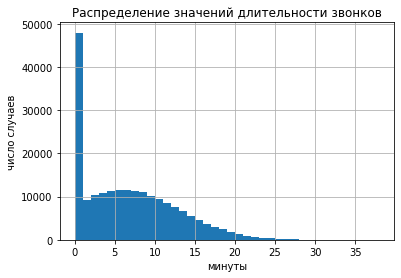

In [21]:
plt.title('Распределение значений длительности звонков')
plt.xlabel('минуты')
plt.ylabel('число случаев')
calls['duration'].hist(bins=38); #Оценка распределения и выбросов

Характер распределения значений нормальный. Разброс значений от 0 до 38 мин - в пределах нормы. Нулевые значения имеют признаки выбросов. Среднее и медиана - 6.8 мин и 6 мин соответсвенно.

Отбросим строки с нулевыми значениями и оценим изменения.

In [22]:
calls = calls.loc[calls['duration']>0]

In [23]:
calls['duration'].describe() #Оценка средних и отклонений после преобразований

count    162994.000000
mean     8.397794     
std      5.353022     
min      0.010000     
25%      4.170000     
50%      7.740000     
75%      11.850000    
max      38.000000    
Name: duration, dtype: float64

После удаления нулей  среднее и медиана увеличились - 8.4 мин и 7.7 мин соответсвенно. На самом деле средний звонок длится на четверть дольше, чем мы полагали до очистки данных.

#### Объем интернет-трафика

In [24]:
internet['mb_used'].describe() #Оценка средних и отклонений

count    149396.000000
mean     370.192426   
std      278.300951   
min      0.000000     
25%      138.187500   
50%      348.015000   
75%      559.552500   
max      1724.830000  
Name: mb_used, dtype: float64

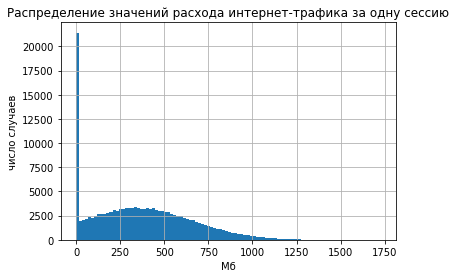

In [25]:
plt.title('Распределение значений расхода интернет-трафика за одну сессию')
plt.xlabel('Мб')
plt.ylabel('число случаев')
internet['mb_used'].hist(bins=100); #Оценка распределения и выбросов

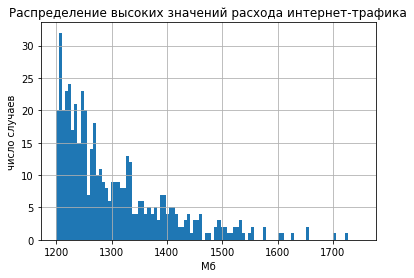

In [26]:
plt.title('Распределение высоких значений расхода интернет-трафика')
plt.xlabel('Мб')
plt.ylabel('число случаев')
internet['mb_used'].hist(bins=100, range=(1200,1750));

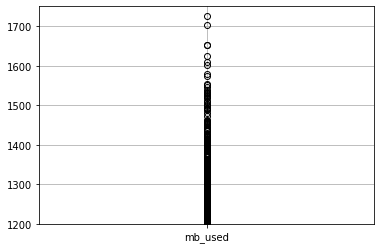

In [27]:
plt.ylim(1200, 1750)
internet.boxplot(column='mb_used');

In [28]:
#Доля значений более 1250 Мб в общем числе.
len(internet.query('mb_used >1250'))/len(internet)

0.0019813114139602133

In [29]:
internet.query('mb_used >1250')['mb_used'].sum()/internet['mb_used'].sum()

0.007239673659202085

Характер распределения значений нормальный. На долю высоких значений от 1250 Мб (0,2% от общего числа) приходится 0,7% от всего трафика. Такие доли не являются статистически значимыми. На значениях более 1250 наблюдается плавная нисходящая динамика гистограммы и её дискретность с незначительными интервалами между значениями. Следует игнорировать высокие значения, т.к. их наличие не отразится на результах исследования, а отсутсвие даст искаженную картину в разрезе использованного трафика по отдельным пользователям.

Разброс значений от 0 до 1725 Мб находится в пределах нормы.  Нулевые значения имеют признаки выбросов. Среднее и медиана - 370 и 348 Мб соответсвенно.

Отбросим строки с нулевыми значениями и оценим изменения.

In [30]:
internet = internet.loc[internet['mb_used']>0]

In [31]:
internet['mb_used'].describe() #Оценка средних и отклонений после преобразований

count    129798.000000
mean     426.087210   
std      255.596447   
min      0.030000     
25%      227.460000   
50%      400.540000   
75%      592.947500   
max      1724.830000  
Name: mb_used, dtype: float64

После удаления нулей среднее и медиана увеличились - 426 и 400 Мб соответсвенно. В среднем пользователь тратит на 15% больше трафика за сессию, чем мы полагали до очистки данных.

### Вывод

Мы провели первичный анализ и обработку данных: 

* Проверили данные на наличие дубликатов. В таблице `internet` удалили столбец, дублирующий индексы.
* Заменили типы данных в столбцах: `call_date`, `session_date`, `churn_date`, `reg_date`, `message_date` на datetime. 
* Тип данных столбцов `user_id` заменили на более компактный int32.
* Выявили и отбросили нулевые значения в столбцах `calls['duration']` и `internet['mb_used']`, которые влияли на характер распределения и статистические метрики этих видов трафика. Нули могут появиться в результате пропущенных вызовов, мгновенного подключения к интернету со стороны пользователя или тестовых запусков приложений с объемом трафика до 10 Кб. После удаления нулей средние значения увеличились на 25% и 15% сответсвенно.

## Рассчёты и добавление результатов в таблицу

### Дополнение и группировка данных трафика

- Дополним таблицы `calls`, `internet` и `messages` столбцами `month` с порядковым номером месяца методом .dt.month.
- Дополним таблицу `calls` столбцом `duration_estimated` с округленной до целых минут в большую сторону длительностью звонка.
- Дополним таблицу `internet` столбцом `mb_used_estimated` с округленным до целых Мб в большую сторону трафиком.
- Создадим таблицы `calls_grouped`, `internet_grouped` и `messages_grouped`, сгруппированные по столбцам `user_id` и `month`. 

In [32]:
calls['duration_estimated'] = calls['duration'].apply(np.ceil).astype('int')

In [33]:
calls['month'] = calls['call_date'].dt.month
calls.sample(5)

,id,call_date,duration,user_id,duration_estimated,month
48347,1121_4,2018-11-04,8.65,1121,9,11
145756,1370_142,2018-05-22,13.62,1370,14,5
167878,1413_88,2018-12-05,7.70,1413,8,12
113495,1291_121,2018-03-01,13.11,1291,14,3
85268,1213_314,2018-11-10,13.76,1213,14,11


In [34]:
calls_grouped = calls.groupby(['user_id','month']).agg( #группируем по двум столбцам
        calls_count=pd.NamedAgg(column="id", aggfunc='count'), #добавляем столбец с количеством звонков
        calls_duration_total=pd.NamedAgg(column="duration_estimated", aggfunc='sum') #добавляем столбец с общей длительностью звонков
    ).reset_index()  #сбросим индексы
calls_grouped #выведем результат группировки

,user_id,month,calls_count,calls_duration_total
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466
...,...,...,...,...
3163,1498,10,30,247
3164,1499,9,8,70
3165,1499,10,44,449
3166,1499,11,62,612


In [35]:
internet['mb_used_estimated'] = internet['mb_used'].apply(np.ceil).astype('int')

In [36]:
internet['month'] = internet['session_date'].dt.month
internet.sample(5)

,id,user_id,session_date,mb_used,mb_used_estimated,month
137926,1464_150,1464,2018-08-23,203.86,204,8
77482,1262_134,1262,2018-04-07,700.73,701,4
118720,1401_141,1401,2018-06-30,128.22,129,6
130040,1433_235,1433,2018-04-25,137.59,138,4
98453,1330_661,1330,2018-07-03,277.52,278,7


In [37]:
internet_grouped = internet.groupby(['user_id','month']).agg( #группируем по двум столбцам
        mb_used_total=pd.NamedAgg(column="mb_used_estimated", aggfunc='sum') #добавляем столбец с общим объемом трафика
    ).reset_index() #сбросим индексы
internet_grouped #выведем результат группировки

,user_id,month,mb_used_total
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
...,...,...,...
3196,1498,10,20604
3197,1499,9,1848
3198,1499,10,17809
3199,1499,11,17984


In [38]:
messages['month'] = messages['message_date'].dt.month
messages.sample(5)

,id,message_date,user_id,month
13642,1056_224,2018-09-06,1056,9
84679,1354_131,2018-10-27,1354,10
71137,1300_889,2018-10-23,1300,10
58719,1257_511,2018-11-27,1257,11
23672,1097_187,2018-09-17,1097,9


In [39]:
messages_grouped = messages.groupby(['user_id','month']).agg( #группируем по двум столбцам
        messages_count=pd.NamedAgg(column="id", aggfunc='count') #добавляем столбец с количеством смс
    ).reset_index() #сбросим индексы
messages_grouped #выведем результат группировки

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


### Объединение таблиц

Объединим поочередно таблицы методом .merge по столбцам `user_id`,`month` в таблицу `data`. В финальную таблицу включим столбцы: 'user_id','month','calls_count','calls_duration_total','mb_used_total','messages_count','reg_date','churn_date','city','tariff'. 

In [40]:
data = calls_grouped.merge(internet_grouped, on=['user_id','month'], how='outer') 
data = data.merge(messages_grouped, on=['user_id','month'], how='outer') 
users.query('user_id > 1499 or user_id < 1000')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


In [41]:
users.query('user_id == 1128 or user_id == 1371')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


In [42]:
data = data.merge(users, on='user_id', how='left') 
data

,user_id,month,calls_count,calls_duration_total,mb_used_total,messages_count,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,17.0,159.0,2256.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,28.0,172.0,23257.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,41.0,340.0,14016.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,42.0,408.0,14070.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,46.0,466.0,14581.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,NaN,NaN,11066.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3210,1489,9,NaN,NaN,17232.0,32.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3211,1489,10,NaN,NaN,19588.0,21.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3212,1489,11,NaN,NaN,17516.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart


In [43]:
users.query('user_id == 1128 or user_id == 1371')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


При слиянии таблиц по ключам из таблицы `users` отбросились 2 id. Абоненты так и не воспользовались услугами и вышли из тарифа в течение недели.

У нас образовались пропуски, вероятно клиент попросту не пользовался какой-то услугой в определенный месяц, поэтому можно заполнить пропуски нулем.

In [44]:
data = data[['user_id','month','calls_count','calls_duration_total','mb_used_total','messages_count',
             'reg_date','churn_date','city','tariff']]

data['calls_count']=data.loc[:,'calls_count'].fillna(0).astype('int')
data['calls_duration_total']=data.loc[:,'calls_duration_total'].fillna(0).astype('int')
data['mb_used_total']=data.loc[:,'mb_used_total'].fillna(0).astype('int')
data['messages_count']=data.loc[:,'messages_count'].fillna(0).astype('int')

data #Вывод результата объединения

,user_id,month,calls_count,calls_duration_total,mb_used_total,messages_count,reg_date,churn_date,city,tariff
0,1000,5,17,159,2256,22,2018-05-25,NaT,Краснодар,ultra
1,1000,6,28,172,23257,60,2018-05-25,NaT,Краснодар,ultra
2,1000,7,41,340,14016,75,2018-05-25,NaT,Краснодар,ultra
3,1000,8,42,408,14070,81,2018-05-25,NaT,Краснодар,ultra
4,1000,9,46,466,14581,57,2018-05-25,NaT,Краснодар,ultra
...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0,0,11066,17,2018-08-15,NaT,Санкт-Петербург,smart
3210,1489,9,0,0,17232,32,2018-08-15,NaT,Санкт-Петербург,smart
3211,1489,10,0,0,19588,21,2018-08-15,NaT,Санкт-Петербург,smart
3212,1489,11,0,0,17516,20,2018-08-15,NaT,Санкт-Петербург,smart


### Расчет помесячной выручки по клиентам

- Напишем функцию для подсчета выручки в каждой строке таблицы - `revenue`.
- Дополним таблицу `data` столбцом `revenue`. Значения столбца получим применением функции `revenue` к таблице данных методом .apply().

In [45]:
tariffs # Информация о тарифах

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [46]:
# Функция для подсчета выручки в каждой строке таблицы
def revenue(row):
    tariff = row['tariff']
    minutes = row['calls_duration_total']
    mb = row['mb_used_total']
    messages = row['messages_count']
    for row in data:
        if tariff == 'smart': #для тарифа "Смарт"
     #выручка со звонков - положительная разница между числом потраченных минут и лимитом минут тарифа, умноженная на цену минуты       
            if minutes > tariffs.loc[0,'minutes_included']: 
                min_rev = (minutes - tariffs.loc[0,'minutes_included'])*tariffs.loc[0,'rub_per_minute'] 
            else:
                min_rev = 0 #если разница отрицательная, выручка = 0
     #выручка с интернет-трафика - положительная разница между числом потраченных Гб, округленных до целых в большую сторону и лимитом Гб тарифа, умноженная на цену Гб (1024Мб в 1 Гб)           
            if mb > tariffs.loc[0,'mb_per_month_included']:
                mb_rev = np.ceil((mb - tariffs.loc[0,'mb_per_month_included']) / 1024) * tariffs.loc[0,'rub_per_gb'] 
            else:
                mb_rev = 0   
     #выручка с сообщений - положительная разница между числом отправленных сообщений и лимитом сообщений тарифа, умноженная на цену сообщения
            if messages > tariffs.loc[0,'messages_included']:
                mess_rev = (messages - tariffs.loc[0,'messages_included'])*tariffs.loc[0,'rub_per_message']
            else:
                mess_rev = 0  
     #выручка по строке - сумма выручек со звонков, интернет-трафика и сообщений и ежемесячной платы за тариф 
            revenue = min_rev+mb_rev+mess_rev+tariffs.loc[0,'rub_monthly_fee']
        if tariff == 'ultra':  #для тарифа "Ультра" алгоритм повторяется
            if minutes > tariffs.loc[1,'minutes_included']:
                min_rev = (minutes - tariffs.loc[1,'minutes_included'])*tariffs.loc[1,'rub_per_minute']
            else:
                min_rev = 0
            if mb > tariffs.loc[1,'mb_per_month_included']:
                mb_rev = np.ceil((mb - tariffs.loc[1,'mb_per_month_included']) / 1024) * tariffs.loc[1,'rub_per_gb'] 
            else:
                mb_rev = 0   
            if messages > tariffs.loc[1,'messages_included']:
                mess_rev = (messages - tariffs.loc[1,'messages_included'])*tariffs.loc[1,'rub_per_message']
            else:
                mess_rev = 0                         
            revenue = min_rev+mb_rev+mess_rev+tariffs.loc[1,'rub_monthly_fee']
        return round(revenue,2) #округляем до 2х знаков после точки

In [47]:
data['revenue'] = data.apply(revenue, axis = 1).astype('int')
data

,user_id,month,calls_count,calls_duration_total,mb_used_total,messages_count,reg_date,churn_date,city,tariff,revenue
0,1000,5,17,159,2256,22,2018-05-25,NaT,Краснодар,ultra,1950
1,1000,6,28,172,23257,60,2018-05-25,NaT,Краснодар,ultra,1950
2,1000,7,41,340,14016,75,2018-05-25,NaT,Краснодар,ultra,1950
3,1000,8,42,408,14070,81,2018-05-25,NaT,Краснодар,ultra,1950
4,1000,9,46,466,14581,57,2018-05-25,NaT,Краснодар,ultra,1950
...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0,0,11066,17,2018-08-15,NaT,Санкт-Петербург,smart,550
3210,1489,9,0,0,17232,32,2018-08-15,NaT,Санкт-Петербург,smart,950
3211,1489,10,0,0,19588,21,2018-08-15,NaT,Санкт-Петербург,smart,1550
3212,1489,11,0,0,17516,20,2018-08-15,NaT,Санкт-Петербург,smart,1150


Оценим распределение выручки в столбце `revenue`.

<AxesSubplot:title={'center':'Распределение значений выручки по абонентам в месяц'}, xlabel='рублей', ylabel='число случаев'>

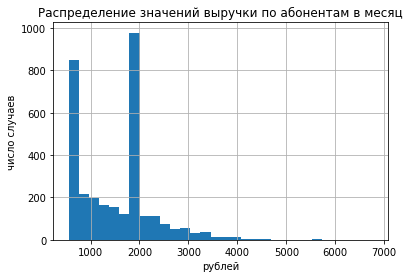

In [48]:
plt.title('Распределение значений выручки по абонентам в месяц')
plt.xlabel('рублей')
plt.ylabel('число случаев')
data['revenue'].hist(bins=30)

Два пика на гистограмме - абонплата по тарифам: 550 и 1950 руб.
Посмотрим, нет ли среди "заплативших много" явных выбросов. Сделаем выборку данных, когда месячная выручка превысила 4000 руб.

In [49]:
data.query('revenue>4000')

,user_id,month,calls_count,calls_duration_total,mb_used_total,messages_count,reg_date,churn_date,city,tariff,revenue
260,1042,12,94,728,37219,75,2018-11-25,NaT,Хабаровск,smart,5709
423,1066,8,61,587,31017,46,2018-06-24,NaT,Астрахань,smart,4011
615,1098,12,63,588,36568,14,2018-06-23,NaT,Челябинск,smart,5014
782,1124,10,130,1225,49789,121,2018-09-24,NaT,Махачкала,ultra,4800
856,1138,8,90,859,28870,3,2018-07-13,NaT,Екатеринбург,smart,4427
1000,1159,12,85,734,35178,2,2018-11-28,NaT,Красноярск,smart,5252
1069,1172,6,59,541,33927,2,2018-05-05,NaT,Санкт-Петербург,smart,4473
1073,1172,10,45,356,32781,4,2018-05-05,NaT,Санкт-Петербург,smart,4150
1359,1216,12,162,1435,20095,64,2018-11-23,NaT,Волгоград,smart,4397
1452,1229,12,106,1022,25033,6,2018-10-29,NaT,Москва,smart,4116


Из таблицы видно,что в большинстве таких случаев использовался тариф Smart с меньшим пакетом трафика. Все они заплатили бы меньше, если бы использовали другой тариф. Те, кто использовал тариф Ultra, заплатили много из-за значительного превышения лимита интернет-трафика. В таблице пользователи встречаются не более 2х раз. Но это не значит, что превышение лимитов трафика встречается единожды за период наблюдения. У высоких значений нет явных признаков ошибок и выбросов.

### Вывод

В ходе проведения расчетов мы подготовили данные для дальнейшего исследования:

- Дополнили таблицы `calls`, `internet` и `messages` столбцами `month` с порядковым номером месяца.
- Дополнили таблицу `calls` столбцом `duration_estimated` с округленной до целых минут в большую сторону длительностью звонка.
- Дополнили таблицу `internet` столбцом `mb_used_estimated` с округленным до целых Мб в большую сторону трафиком.
- Создали таблицы `calls_grouped`, `internet_grouped` и `messages_grouped`, сгруппированные по столбцам `user_id` и `month`. 
- Объединили таблицу `users` и сгруппированные таблицы по столбцам `user_id` и `month` в сводную таблицу `data`.
- Дополнили таблицу `data` столбцом `revenue` с помесячной выручкой по каждому абоненту.
- Проверили полученные данные по выручке на наличие ошибок и выбросов.
- Установили, что в большинстве случаев, когда выручка превысила 4000 руб. в месяц, использовался тариф Smart с меньшим пакетом трафика. Такие пользователи заплатили бы меньше, если бы использовали другой тариф. Те, кто использовал тариф Ultra, заплатили много из-за значительного превышения лимита интернет-трафика.

## Анализ использования тарифов

Разделим данные на две таблицы в разрезе тарифов. Выведем статистическое описание данных методом .describe().

In [50]:
data_smart = data.query('tariff == "smart"')
data_smart.describe()

,user_id,month,calls_count,calls_duration_total,mb_used_total,messages_count,revenue
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,1246.506505,8.346792,46.947510,417.934948,16229.188425,33.384029,1294.639300
std,146.119496,2.920316,21.039171,190.313730,5877.576978,28.227876,820.933202
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,550.000000
25%,1121.000000,6.000000,32.000000,282.000000,12658.000000,10.000000,550.000000
50%,1239.000000,9.000000,47.000000,422.000000,16531.000000,28.000000,1038.000000
75%,1376.000000,11.000000,61.000000,545.000000,20068.000000,51.000000,1750.000000
max,1499.000000,12.000000,162.000000,1435.000000,38610.000000,143.000000,6770.000000


In [51]:
data_ultra = data.query('tariff == "ultra"')
data_ultra.describe()

,user_id,month,calls_count,calls_duration_total,mb_used_total,messages_count,revenue
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,1263.094416,8.250761,59.236548,526.623350,19486.901523,49.363452,2071.065990
std,140.694908,2.871762,35.562722,317.606098,10096.317202,47.804457,378.802377
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1950.000000
25%,1143.000000,6.000000,33.000000,284.000000,11785.000000,6.000000,1950.000000
50%,1277.000000,9.000000,58.000000,518.000000,19324.000000,38.000000,1950.000000
75%,1381.000000,11.000000,84.000000,752.000000,26863.000000,79.000000,1950.000000
max,1495.000000,12.000000,190.000000,1673.000000,49789.000000,224.000000,4800.000000


Сгруппируем в таблицы исследуемые статистические метрики: среднее, вариацию и стандартное отклонение по видам трафика в разрезе тарифов.

In [52]:
#Группировка статистических метрик в таблицу по тарифу Smart
a=['traffic_type','mean','variance','standard_deviation'] #список названий столбцов
b=[['calls_duration',round(data_smart['calls_duration_total'].mean()),#продолжительность звонков: среднее, дисперсия, отклонение
    round(np.var(data_smart['calls_duration_total'], ddof=1)),
   round(np.std(data_smart['calls_duration_total'], ddof=1))],
   ['mb_used',round(data_smart['mb_used_total'].mean()), #интернет-трафик: среднее, дисперсия, отклонение
    round(np.var(data_smart['mb_used_total'], ddof=1)),
    round(np.std(data_smart['mb_used_total'], ddof=1))],
  ['messages',round(data_smart['messages_count'].mean()), #сообщения: среднее, дисперсия, отклонение
   round(np.var(data_smart['messages_count'], ddof=1)),
   round(np.std(data_smart['messages_count'], ddof=1))]
  ]
smart_stat=pd.DataFrame(columns=a, data=b) #объединяем данные в таблицу Data Frame

In [53]:
#Группировка статистических метрик в таблицу по тарифу Ultra
c=['traffic_type','mean','variance','standard_deviation'] #список названий столбцов
d=[['calls_duration',round(data_ultra['calls_duration_total'].mean()), #продолжительность звонков: среднее, дисперсия, отклонение
    round(np.var(data_ultra['calls_duration_total'], ddof=1)),
   round(np.std(data_ultra['calls_duration_total'], ddof=1))],
   ['mb_used',round(data_ultra['mb_used_total'].mean()), #интернет-трафик: среднее, дисперсия, отклонение
    round(np.var(data_ultra['mb_used_total'], ddof=1)),
    round(np.std(data_ultra['mb_used_total'], ddof=1))],
  ['messages',round(data_ultra['messages_count'].mean()), #сообщения: среднее, дисперсия, отклонение
   round(np.var(data_ultra['messages_count'], ddof=1)),
   round(np.std(data_ultra['messages_count'], ddof=1))]
  ]
ultra_stat=pd.DataFrame(columns=c, data=d) #объединяем данные в таблицу Data Frame

In [54]:
#вывод таблиц на экран
print('Статистические метрики тарифа Smart за месяц')
display(smart_stat)
print('-'*45)
print('Статистические метрики тарифа Ultra за месяц')
display(ultra_stat)

Статистические метрики тарифа Smart за месяц


,traffic_type,mean,variance,standard_deviation
0,calls_duration,418,36219,190
1,mb_used,16229,34545911,5878
2,messages,33,797,28


---------------------------------------------
Статистические метрики тарифа Ultra за месяц


,traffic_type,mean,variance,standard_deviation
0,calls_duration,527,100874,318
1,mb_used,19487,101935621,10096
2,messages,49,2285,48


Видим, что абоненты тарифа Ультра в среднем потребляют больше и вариативнее.

Для дальнейшего анализа объявим функции.

In [55]:
#Функция для вывода диаграммы и сводной таблицы сравнения среднемесячных метрик тарифов
def monthly_stat(column,title,ylim2): #аргументы: столбец с метрикой, название диаграммы, верхний предел у-оси
    pivot1 = data_smart.pivot_table(index='month',values=column, aggfunc='mean') #сводная таблица по тарифу smart 
    pivot2 = data_ultra.pivot_table(index='month',values=column, aggfunc='mean') #сводная таблица по тарифу ultra 
    pivot3 = pivot1.join(pivot2, rsuffix='_u') #объединение двух таблиц
    pivot3.columns = ['smart','ultra'] #переименование столбцов
    pivot3['smart']=round(pivot3['smart']).astype('int') #округление значений
    pivot3['ultra']=round(pivot3['ultra']).astype('int') 
    print(pivot3) #общая сводной таблицы
    return pivot3.plot.bar(title=title,figsize=(12,4),ylim=(0, ylim2)); #диаграмма по таблице

In [56]:
#Функция для попарного вывода гистограммы распределения и графика оценки плотности KDE для сравнения среднемесячных метрик тарифов
def compare_plot(column,title,xlablel,binwidth): #аргументы: столбец с метрикой,название диаграммы,подпись х-оси,ширина корзины
    sns.set_style('white', #установка стиля seaborn-графика: белая тема, сетка
              {'axes.grid': True})
    sns.set(font_scale=1)  #установка масштаба шрифта seaborn-графика
    plt.figure(figsize=(12,6)) #присваивание размеров графика, подписей осей и названия matplotlib-графика
    plt.title(title)
    plt.xlabel(xlablel)
    plt.ylabel('число случаев')
    ax = sns.histplot(data=data, #объединение графиков по двум тарифам через аргументы hue="tariff" и ах=ах
        x=column,              
        binwidth=binwidth, #ширина корзины
        kde=True,
        hue="tariff", 
    );
    sns.histplot(data=data,
        x=column,
        stat='count',
        binwidth=binwidth,
        kde=True,
        palette="bright", #палитра
        hue="tariff", 
        ax=ax,
        legend=True,
        common_bins=True,
        alpha=0.3,
     );
    plt.show()
    return ax

### Количество минут разговора

Сравним среднемесячное количество минут и распределение среднемесячной продолжительности звонков по двум тарифам.

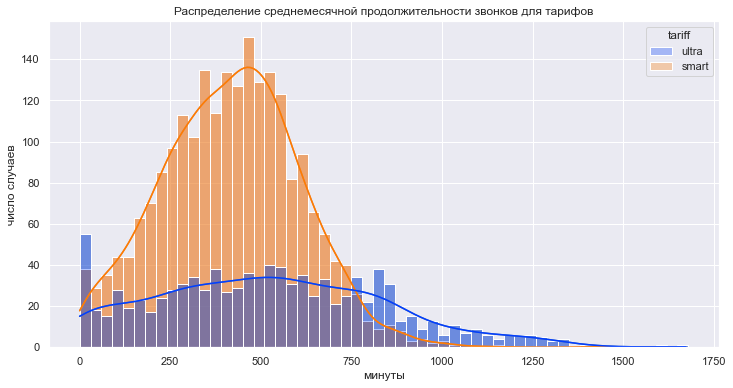

<AxesSubplot:title={'center':'Распределение среднемесячной продолжительности звонков для тарифов'}, xlabel='минуты', ylabel='число случаев'>

In [57]:
compare_plot('calls_duration_total','Распределение среднемесячной продолжительности звонков для тарифов','минуты',30)

       smart  ultra
month              
1      204    428  
2      299    297  
3      390    490  
4      367    458  
5      387    510  
6      396    480  
7      408    546  
8      421    511  
9      429    539  
10     426    558  
11     435    541  
12     479    593  


<AxesSubplot:title={'center':'Среднемесячное количество минут разговора по тарифам'}, xlabel='month'>

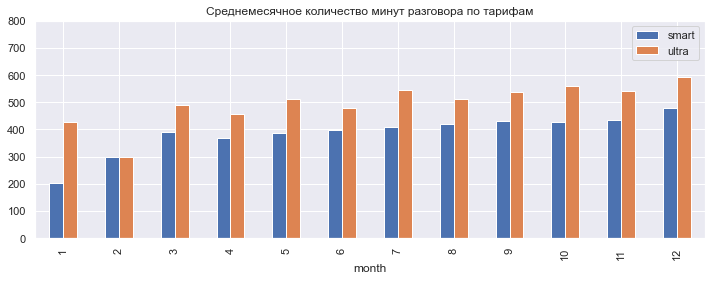

In [58]:
monthly_stat('calls_duration_total','Среднемесячное количество минут разговора по тарифам',800)

Распределения значений по обоим тарифам имеют признаки нормального. По правилу трех сигм прибавим к середнему значению 3 стандартных отклонения и расчитаем верхнюю границу значений, за которой лежат редкие значения и возможные выбросы. Таким образом, выборка будет характеризовать поведение подавляющего большинства абонентов (не менее 99%).

In [59]:
#верхняя граница значений по правилу трех сигм
print('smart',smart_stat[
    smart_stat['traffic_type']=="calls_duration"]['mean']+smart_stat[
    smart_stat['traffic_type']=="calls_duration"]['standard_deviation']*3)
print( )
print('ultra',smart_stat[
    ultra_stat['traffic_type']=="calls_duration"]['mean']+ultra_stat[
    ultra_stat['traffic_type']=="calls_duration"]['standard_deviation']*3)

smart 0    988
dtype: int64

ultra 0    1372
dtype: int64


Оценим целесообразность использования тарифов в отдельных месяцах для данной метрики.

In [60]:
#Доля случаев превышения лимита тарифа Smart за месяц
len(data_smart.query('calls_duration_total>500'))/len(data_smart)

0.3382682817406909

In [61]:
#Доля случаев для тарифа Ultra, когда длительность звонков не больше 500 мин за месяц
len(data_ultra.query('calls_duration_total<=500'))/len(data_ultra)

0.47715736040609136

#### Вывод:

* Распределения значений по обоим тарифам имеют признаки нормального, скошенны вправо. 
* И график распределения, и значения стандартного отклонения демонстрируют различный характер распределений. Для Smart характерна высокая частотность вблизи медианы, а для Ultra - более равномерное распределение значений по частотности. Т.о. вероятность встретить относительно низкие и высокие значения для Ultra выше.
* В среднем по тарифу **Smart** расходуют около 418 минут. Типичный абонент разговаривает от 282 до 545 минут в месяц. Почти все пользователи (99%) разговаривают не более 988 минут в месяц. В 34% случаев лимит тарифа по минутам в месяц превышался.
* В среднем по тарифу **Ultra** расходуют около 527 минут - на четверть больше, чем для Smart. Типичный абонент разговаривает от 284 до 752 минут в месяц. Почти все пользователи (99%) разговаривают не более 1372 минут в месяц. В 48% случаев абоненты разговаривают не более 500 минут в месяц.
* Ожидаемо, что для высоких значений - более 750 минут - количество наблюдений выше для более объемного тарифа Ultra.
* График демонстрирует сезонную зависимость количества минут разговора. Выражена тенденция к увеличению времени разговоров на протяжении года. 
* По тарифу **Smart**: в январе-феврале регистрируется низкая активность абонентов (на 30-50% ниже среднегодовой), затем всплеск активности в марте и августе, и максимальная активность в декабре (на 15% выше среднегодовой). 
* По тарифу **Ultra**: график демонстрирует качели - перепады активности в течение года с сохранением общей тенденци к нарастанию активности к концу года. Такое поведение может быть обусловлено в том числе и небольшим размером выборки по тарифу. При этом в январе абоненты говорят по телефону в среднем в 2 раза больше, чем абоненты на тарифе Smart, а в феврале их активность сравнивается. В декабре длительность разговоров на 13% выше среднегодовой.   
* Абоненты на тарифе Ultra гораздо чаще не пользуются звонками вообще. Очевидно, они выбрали тариф ради другого типа связи - интернета.

### Объем интернет-трафика

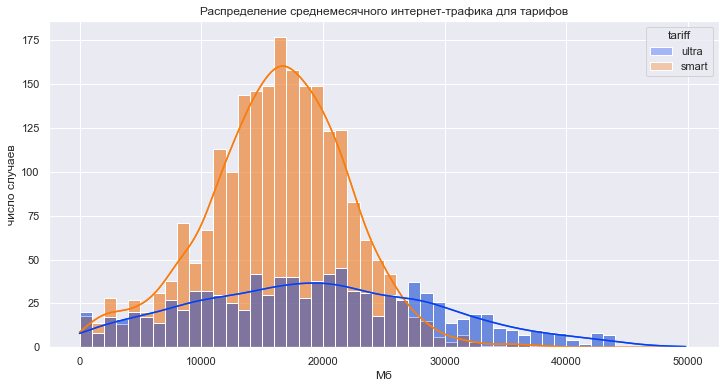

<AxesSubplot:title={'center':'Распределение среднемесячного интернет-трафика для тарифов'}, xlabel='Мб', ylabel='число случаев'>

In [62]:
compare_plot('mb_used_total','Распределение среднемесячного интернет-трафика для тарифов','Мб',1000)

       smart  ultra
month              
1      8524   13154
2      11611  11787
3      15124  17552
4      13479  16844
5      15825  19381
6      15815  18942
7      15764  20515
8      16632  19594
9      16325  19222
10     16779  20064
11     16918  19805
12     18137  21814


<AxesSubplot:title={'center':'Среднемесячный объем потребляемого интернет-трафика по тарифам'}, xlabel='month'>

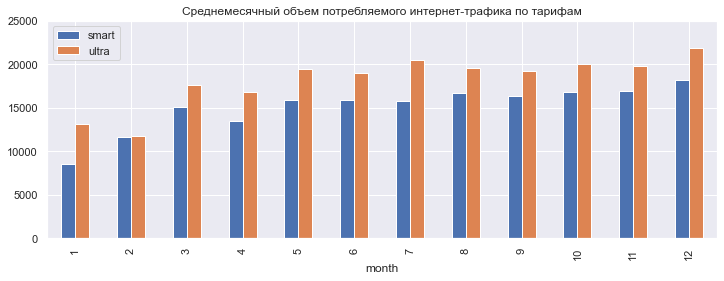

In [63]:
monthly_stat('mb_used_total','Среднемесячный объем потребляемого интернет-трафика по тарифам',25000)

Распределения значений по обоим тарифам имеют признаки нормального. По правилу трех сигм прибавим к середнему значению 3 стандартных отклонения и расчитаем верхнюю границу значений, за которой лежат редкие значения и возможные выбросы. Таким образом, выборка будет характеризовать поведение подавляющего большинства абонентов (не менее 99%).

In [64]:
#верхняя граница значений по правилу трех сигм
print('smart',smart_stat[
    smart_stat['traffic_type']=="mb_used"]['mean']+smart_stat[
    smart_stat['traffic_type']=="mb_used"]['standard_deviation']*3)
print( )
print('ultra',smart_stat[
    ultra_stat['traffic_type']=="mb_used"]['mean']+ultra_stat[
    ultra_stat['traffic_type']=="mb_used"]['standard_deviation']*3)

smart 1    33863
dtype: int64

ultra 1    46517
dtype: int64


Оценим целесообразность использования тарифов в отдельных месяцах для данной метрики.

In [65]:
#Доля случаев превышения лимита тарифа Smart за месяц
len(data_smart.query('mb_used_total>15360'))/len(data_smart)

0.5872588604755495

In [66]:
#Доля случаев для тарифа Ultra, когда расход трафика не больше 15360 Мб за месяц
len(data_ultra.query('mb_used_total<=15360'))/len(data_ultra)

0.35431472081218274

In [67]:
#Доля случаев превышения лимита тарифа Ultra за месяц
len(data_ultra.query('mb_used_total>30720'))/len(data_ultra)

0.13604060913705585

#### Вывод:

* Распределения значений по обоим тарифам имеют признаки нормального.
* И график распределения, и значения стандартного отклонения демонстрируют различный характер распределений. Для Smart характерна высокая частотность вблизи медианы, а для Ultra - более равномерное распределение значений по частотности. Т.о. вероятность встретить относительно низкие и высокие значения для Ultra выше.
* В среднем по тарифу **Smart** расходуют 16229 Мб. Типичный абонент расходует от 12658 до 20068 Мб в месяц. Почти все пользователи (99%) расходуют не более 33863 Мб в месяц. В 59% случаев лимит тарифа по интернет-трафику в месяц превышался.
* В среднем по тарифу **Ultra** расходуют 19487 Мб- на 20% больше, чем для Smart. Типичный абонент расходует от 11785 до 26863 Мб в месяц. Почти все пользователи (99%) расходуют не более 46517 Мб в месяц. В 35% случаев абоненты расходуют не более 15360 Мб в месяц.
* Ожидаемо, что для высоких значений - более 27000 Мб - количество наблюдений выше для более объемного тарифа Ultra.
* График демонстрирует сезонную зависимость количества израсходованных Мб. Выражена тенденция к увеличению объемов интернет-трафика на протяжении года. Аналогичная динамика наблюдается при изучении длительности звонков.
* По тарифу **Smart**: в январе-феврале регистрируется низкая активность абонентов (на 30-50% ниже среднегодовой), затем всплеск активности в марте и августе, и максимальная активность в декабре (на 12% выше среднегодовой). 
* По тарифу **Ultra**: график демонстрирует качели - перепады активности в течение года с сохранением общей тенденци к нарастанию активности к концу года. При этом в январе абоненты расходуют среднем в 1,5 раза больше Мб, чем абоненты на тарифе Smart, а в феврале их активность сравнивается. В декабре объем трафика на 12% выше среднегодового. 
* Почти в каждом седьмом случае лимит интернет-трафика по тарифу Ultra превышался. Прибавим к этому наблюдению тот факт, что похожая проблема характерна для трех из пяти случаев по тарифу Smart. Всё это может сигнализировать о необходимости пересмотра  пакетов тарифных планов. В противном случае, существует риск оттока клиентов к конкурентам.

### Количество сообщений

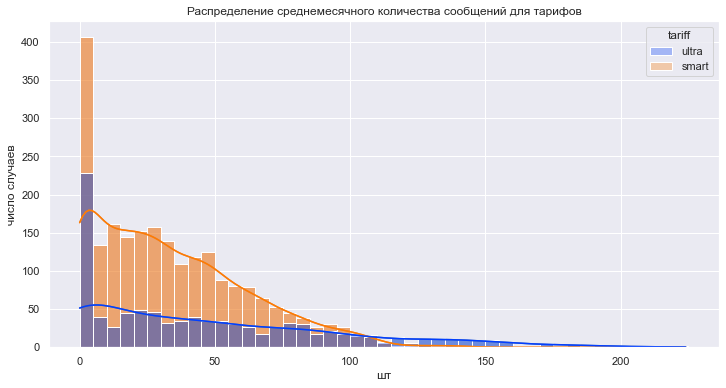

<AxesSubplot:title={'center':'Распределение среднемесячного количества сообщений для тарифов'}, xlabel='шт', ylabel='число случаев'>

In [68]:
compare_plot('messages_count','Распределение среднемесячного количества сообщений для тарифов','шт',5)

       smart  ultra
month              
1      18     34   
2      24     22   
3      32     32   
4      31     32   
5      34     38   
6      33     42   
7      34     50   
8      34     48   
9      34     52   
10     34     58   
11     34     56   
12     36     61   


<AxesSubplot:title={'center':'Среднемесячное количество сообщений по тарифам'}, xlabel='month'>

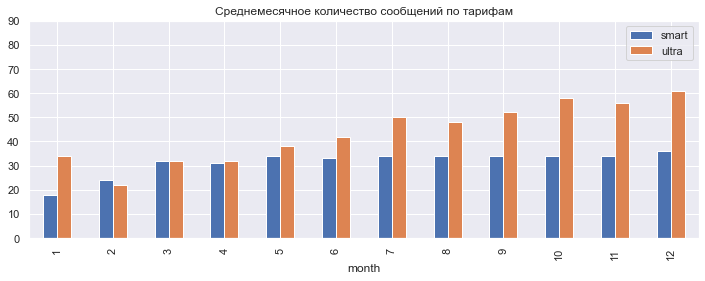

In [69]:
monthly_stat('messages_count','Среднемесячное количество сообщений по тарифам',90)

Распределения значений по обоим тарифам имеют признаки нормального. По правилу трех сигм прибавим к середнему значению 3 стандартных отклонения и расчитаем верхнюю границу значений, за которой лежат редкие значения и возможные выбросы. Таким образом, выборка будет характеризовать поведение подавляющего большинства абонентов (не менее 99%).

In [70]:
#верхняя граница значений по правилу трех сигм
print('smart',smart_stat[
    smart_stat['traffic_type']=="messages"]['mean']+smart_stat[
    smart_stat['traffic_type']=="messages"]['standard_deviation']*3)
print( )
print('ultra',smart_stat[
    ultra_stat['traffic_type']=="messages"]['mean']+ultra_stat[
    ultra_stat['traffic_type']=="messages"]['standard_deviation']*3)

smart 2    117
dtype: int64

ultra 2    177
dtype: int64


Оценим целесообразность использования тарифов в отдельных месяцах для данной метрики.

In [71]:
#Доля случаев превышения лимита тарифа Smart за месяц
len(data_smart.query('messages_count>50'))/len(data_smart)

0.253028263795424

In [72]:
#Доля случаев для тарифа Ultra, число сообщений не больше 50 за месяц
len(data_ultra.query('messages_count<=50'))/len(data_ultra)

0.5949238578680203

In [73]:
#Доля случаев, когда абоненты не отправляли сообщения
len(data.query('messages_count==0'))/len(data)

0.15463596764156815

#### Вывод:

* Распределения значений по обоим тарифам имеют признаки нормального, скошенны вправо. 
* И график распределения, и значения стандартного отклонения демонстрируют различный характер распределений. Для Smart характерна высокая частотность вблизи медианы, а для Ultra - более равномерное распределение значений по частотности. Т.о. вероятность встретить относительно высокие значения для Ultra выше.
* В среднем по тарифу **Smart** отправляют 28 сообщений. Типичный абонент отправляет от 10 до 51 сообщений в месяц. Почти все пользователи (99%) отправляют не более 117 сообщений в месяц. В четверти случаев лимит тарифа по сообщениям в месяц превышался.
* В среднем по тарифу **Ultra** отправляют 49 сообщение - на 75% больше, чем для Smart. Типичный абонент отправляет от 6 до 79 сообщений в месяц. Почти все пользователи (99%) отправляют не более 177 сообщений в месяц. В 60% случаев абоненты  отправляют не более 50 сообщений в месяц.
* Ожидаемо, что для высоких значений - более 115 сообщений - количество наблюдений выше для более объемного тарифа Ultra.
* Тариф **Ultra** содержит лимит на 1000 сообщений в месяц, что с избытком более чем в 4 раза перекрывает максимальную потребность в сообщениях.
* График демонстрирует сезонную зависимость количества сообщений. Выражена тенденция к увеличению числа отправленных сообщений на протяжении года. 
* По тарифу **Smart** эта тенденция слабо выражена. Лишь в январе-феврале регистрируется низкая активность абонентов - на 15-35% ниже среднегодовой. Затем на протяжении года наблюдается стабильная активность абонентов около среднего значения.
* По тарифу **Ultra**: график демонстрирует качели - перепады активности в течение года с сохранением общей тенденци к нарастанию активности к концу года. Такое поведение может быть обусловлено в том числе и небольшим размером выборки по тарифу. При этом в январе абоненты отправляют в среднем в 2 раза больше сообщений, чем абоненты на тарифе Smart, а в феврале-апреле их активность сравнивается. В октябре-декабре наблюдается незначительный всплеск активности на 24% выше среднегодовой. 
* В 15% случаев пользователи не отправляли сообщения в течение месяца. Большие пики на графике на нулевом значении, а так же избыточность предложения по пакету сообщений в тарифе Ultra сигнализируют о том, что данный вид связи теряет свою актуальность и популярность у пользователей.

### Сравнение показателей выручки

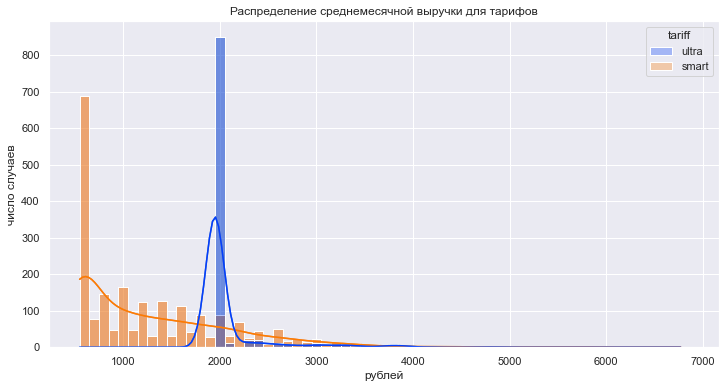

<AxesSubplot:title={'center':'Распределение среднемесячной выручки для тарифов'}, xlabel='рублей', ylabel='число случаев'>

In [74]:
compare_plot('revenue','Распределение среднемесячной выручки для тарифов','рублей',100)

       smart  ultra
month              
1      721    1950 
2      828    1975 
3      1165   2015 
4      963    2002 
5      1205   2062 
6      1209   2041 
7      1229   2121 
8      1329   2083 
9      1255   2024 
10     1370   2067 
11     1347   2093 
12     1583   2139 


<AxesSubplot:title={'center':'Среднемесячная выручка по тарифам'}, xlabel='month'>

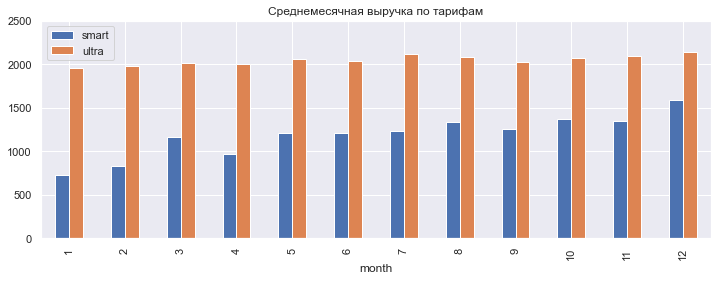

In [75]:
monthly_stat('revenue','Среднемесячная выручка по тарифам',2500)

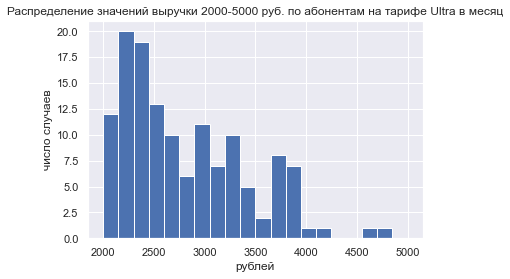

In [76]:
plt.title('Распределение значений выручки 2000-5000 руб. по абонентам на тарифе Ultra в месяц')
plt.xlabel('рублей')
plt.ylabel('число случаев')
data_ultra['revenue'].hist(bins=20, range=(2000,5000));

In [77]:
#Доля случаев превышения абонентской платы по тарифу Smart за месяц
len(data_smart.query('revenue>550'))/len(data_smart)

0.746971736204576

In [78]:
#Доля случаев превышения платы по тарифу Ultra для абонентов тарифа Smart за месяц
len(data_smart.query('revenue>1950'))/len(data_smart)

0.18932256617317184

In [79]:
#Доля случаев превышения абонентской платы по тарифу Ultra за месяц
len(data_smart.query('revenue>1950'))/len(data_smart)

0.18932256617317184

In [80]:
print('Суммарная выручка по тарифу Smart за 2018 год:', data_smart['revenue'].sum(), 'руб.')
print('Годовая выручка по тарифу Smart в расчете на одного абонента:',round(data_smart['revenue'].sum()/len(data_smart['user_id'].unique())),'руб.')
print(' ')
print('Суммарная выручка по тарифу Ultra за 2018 год:', data_ultra['revenue'].sum(), 'руб.')
print('Годовая выручка по тарифу Ultra в расчете на одного абонента:',round(data_ultra['revenue'].sum()/len(data_ultra['user_id'].unique())),'руб.')

Суммарная выручка по тарифу Smart за 2018 год: 2885751 руб.
Годовая выручка по тарифу Smart в расчете на одного абонента: 8245 руб.
 
Суммарная выручка по тарифу Ultra за 2018 год: 2040000 руб.
Годовая выручка по тарифу Ultra в расчете на одного абонента: 13784 руб.


#### Вывод:

* Распределение значений по тарифу **Smart** имеет признаки нормального с ярко выраженным пиком на значении 550 рублей - абонентская плата. 
* По тарифу **Ultra** недостаточное число значений более 1950 рублей в выборке не позволяет судить о нормальности распределения. Отметим ярко выраженный пик на значении 1950 рублей - абонентская плата. 
* И график распределения, и значения стандартного отклонения демонстрируют различный характер распределений. Для Smart характерен больший разброс значений более равномерное нисходящее распределение значений более по частотности.
* Среднемесячная выручка с абонента по тарифу **Smart** составляет 1295 рублей. Типичный абонент тратит на связь от 550 до 1750 рублей в месяц. Т.о. потребность во всех видах трафика для большинства случаев (75%) не обеспечивается базовыми лимитами тарифа. Более того в 21% случаев абоненты могли бы платить за связь меньше, используя тариф Ultra. Отметим, что данное наблюдение справедливо для отдельно взятых месяцев, но не для года в целом.
* Среднемесячная выручка с абонента по тарифу **Ultra** составляет 2071 рубль. Типичный абонент тратит на связь 1950 рублей в месяц. Т.о. потребность во всех видах трафика для большинства случаев (81%) перекрывается базовыми лимитами тарифа.
* Интересно, что для высоких значений - более 1950 рублей - количество наблюдений выше для менее объемного тарифа Smart. Тариф не выгоден для больших объемов трафика, т.к. лимиты пакетов в нем меньше, а цена за единицу трафика выше.
* График по тарифу **Smart** демонстрирует сезонную зависимость выручки. Выражена тенденция к увеличению выручки на протяжении года.
* По тарифу **Ultra** выручка не зависит от сезона.

## Проверка гипотез

Для проверки гипотез сформируем итоговую таблицу: Среднемесячная выручка по абонентам.

In [81]:
rev_per_user = data.groupby('user_id').agg( #группируем по 'user_id'
        mean_revenue=pd.NamedAgg(column="revenue", aggfunc='mean'), #добавляем столбец со среднемесячной выручкой
        tariff=pd.NamedAgg(column="tariff", aggfunc='first'), #добавляем столбец с названиями тарифов
        city=pd.NamedAgg(column="city", aggfunc='first') #добавляем столбец с названиями городов
    ).reset_index()  #сбросим индексы

rev_per_user

,user_id,mean_revenue,tariff,city
0,1000,1950.000000,ultra,Краснодар
1,1001,950.000000,smart,Москва
2,1002,1035.714286,smart,Стерлитамак
3,1003,1950.000000,ultra,Москва
4,1004,1950.000000,ultra,Новокузнецк
...,...,...,...,...
493,1495,2310.000000,ultra,Иркутск
494,1496,2379.250000,smart,Вологда
495,1497,928.333333,smart,Челябинск
496,1498,1659.000000,smart,Владикавказ


### Гипотеза 1

* **Нулевая гипотеза** Н0: средние выручки пользователей тарифов «Ультра» и «Смарт» равны. 
* **Альтернативная гипотеза** Н1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим t-test Стьюдента для езависимых выборок. Применение теста на ненормально распределенных данных оправдано при достаточно большой выборке. Возьмем общепринятое пороговое значение `alpha` — 5%. Если мы признаём 5%-ю вероятность слишком малой и на этом основании отвергаем нулевую гипотезу, значит в среднем в одном исследовании из 20 значимый эффект будет обнаружен не потому, что она неверна, а за счёт случайной ошибки. В ходе исследования мы установили, что стандартные отклонения выручки в выборках по тарифам,  а следовательно и дисперсии не равны и значительно различаются, что дает нам основание полагать, что дисперсии не равны и в генеральных совокупностях. Значение `equal_var` установим как `False`.

In [82]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(data.query('tariff=="smart"')['revenue'], 
                       data.query('tariff=="ultra"')['revenue'], 
                       equal_var = False 
                      )                   
                                   
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.7240946993530846e-246
Отвергаем нулевую гипотезу


### Гипотеза 2

* **Нулевая гипотеза** Н0: средние выручки пользователей из Москвы и других регионов равны. 
* **Альтернативная гипотеза** Н1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Чтобы проверить, гипотезу применим метод scipy.stats.ttest_ind (array1, array2, equal_var). Возьмем общепринятое пороговое значение `alpha` — 5%. Мы не знаем наверняка, равны ли дисперсии в генеральных совокупностях. Значение `equal_var` установим как `True` по умолчанию (не указываем данный аргумент).

In [83]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(data.query('city=="Москва"')['revenue'], 
                       data.query('city!="Москва"')['revenue']                      
                      )

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


### Вывод

* Для Гипотезы №1 полученное значение p-value говорит о том, что мы *отвергаем нулевую гипотезу*. Вероятность случайно получить различные значения выручки в выборках по тарифам близка к нулю. Следовательно можно предположить, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
* Для **Гипотезы №2** полученное значение p-value говорит о том, что *не получилось отвергнуть нулевую гипотезу*, т.к. с вероятностью более 50% разницу между средней выручкой пользователей из Москвы и других регионов можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками.

## Заключение

### Общие выводы

#### Что сделано

***Мы провели статистический анализ данных и сравнили использование тарифов: Smart и Ultra.***

Обработана выборка данных о 500 пользователях «Мегалайна» по двум тарифам за 2018 год:

1. Рассмотрены данные, определены пропуски в них, явные ошибки и несоответствия типу данных.
2. Проведен первичный анализ и предобработка данных.
3. Проверены данные на наличие дубликатов. В таблице `internet` удален столбец, дублирующий индексы.
4. В столбцах с датами изменили тип данных на оптимальный datetime, а в столбцах с id пользователя - на более компактный int32.
5. Данные о длительности звонков и объеме интернет-трафика очищены от нулевых значений, влияющих на характер распределения и статистические метрики этих видов трафика.
6. Произведены расчеты и добавлены в таблицы данные о месяце использования тарифа.
7. По правилу сотового оператора округлены до целых значений в большую сторону число минут и Мб интернет-трафика.
8. Сгруппированы данные по пользователям и месяцам и объединены в сводную таблицу `data`.
9. Для каждого абонента посчитано количество сделанных звонков и израсходованных минут разговора по месяцам,  количество отправленных сообщений по месяцам и объем израсходованного интернет-трафика по месяцам.
10. Расчитана помесячная выручка по каждому абоненту. Полученные данные проверены на наличие ошибок и выбросов.
11. Проанализировано поведение пользователей двух тарифов по объемам потребления различных видов трафика в месяц. Посчитаны среднее количество, дисперсию и стандартное отклонение. Для каждого вида трафика построены и описаны гистограммы распределения и диаграммы сравнения динамики по месяцам.
12. Проанализирована динамика и распределение выручки по двум тарифам.
13. Расчитана среднемесячная выручка по каждому абоненту.
14. Сформулированы и проверены гипотезы о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается и что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

#### Резюме

***Основные выводы и наблюдения:***
1. **Нулевые значения** в данных о длительности звонков и объеме интернет-трафика могли появиться в результате пропущенных вызовов, мгновенного подключения к интернету со стороны пользователя или тестовых запусков приложений с объемом трафика до 10 Кб. А так же в результате ошибок в учете или выгрузке данных. Влияние ошибок в данных на результаты исследования достаточно велико. После удаления нулей средние значения увеличились на 25% и 15% сответсвенно.
2. Каждый из тарифов демонстрирует различный **характер распределений** по видам трафика. Распределения значений по обоим тарифам имеют признаки нормального. Для Smart характерна высокая частотность вблизи медианы, а для Ultra - более равномерное распределение значений по частотности. Т.о. вероятность встретить относительно низкие и высокие значения для Ultra выше. 
3. В целом для высоких значений по всем видам трафика количество наблюдений выше для более объемного тарифа Ultra, чем для Smart.
4. **Средний пользователь тарифа Smart** в месяц расходует около 418 минут, 16229 Мб, отправляет 28 сообщений. *Лимит тарифа в месяц превышался*: по минутами в 34% случаев, по интернет-трафику в 59% случаев, лимит тарифа по сообщениям в 25% случаев.
5. **Средний пользователь тарифа Ultra** в месяц расходует около 527 минут, 19487 Мб, отправляет 49 сообщение. В ряде случаев потребление трафика *не выходит за рамки лимита для меньшего по объему тарифа* Smart: по минутам в 48% случаев, по интернет-трафику в 35% случаев, лимит тарифа по сообщениям в 60% случаев. Почти в каждом седьмом случае лимит интернет-трафика по тарифу  превышался.
6. Наблюдается **сезонная зависимость** по всем видам трафика. Выражена **тенденция к увеличению** активности абонентов на протяжении года. В январе-феврале регистрируется низкая активность абонентов (на 15-50% ниже среднегодовой), затем всплеск активности в марте и августе, и максимальная активность в декабре (на 12-15% выше среднегодовой). При этом в январе пользователи тарифа Ultra используют все виды связи в 1,5-2 раза больше, чем пользователи тарифа Smart, тогда как в феврале их активность сравнивается. 
7. Тариф **Ultra** содержит лимит на 1000 сообщений в месяц, что с избытком более чем в 4 раза перекрывает максимальную потребность в сообщениях.
8. **Среднемесячная выручка** с абонента по тарифу **Smart** составляет 1295 рублей. Типичный абонент тратит на связь от 550 до 1750 рублей в месяц. Т.о. потребность во всех видах трафика для большинства случаев (75%) не обеспечивается базовыми лимитами тарифа. Более того в 21% случаев абоненты могли бы платить за связь меньше, используя тариф Ultra. Отметим, что данное наблюдение справедливо для отдельно взятых месяцев, но не для года в целом.
9. **Среднемесячная выручка** с абонента по тарифу **Ultra** составляет 2071 рубль. Типичный абонент тратит на связь 1950 рублей в месяц. Т.о. потребность во всех видах трафика для большинства случаев (81%) перекрывается базовыми лимитами тарифа. Случаи превышения абонентской платы за тариф, как правило связаны с потреблением интернет-трафика сверх лимита.
10. Для тарифа **Smart** характерна **сезонная зависимость выручки**. Выражена тенденция к увеличению выручки на протяжении года. По тарифу **Ultra выручка не зависит от сезона**.
11. Для высоких значений выручки - более 1950 рублей - количество наблюдений выше для менее объемного тарифа **Smart**. Тариф *не выгоден для больших объемов трафика*, т.к. лимиты пакетов в нем меньше, а цена за единицу трафика выше.
12. Нами проведены статистические тесты, по результатам которых установили:
   * вероятнее всего средние выручки по тарифам «Ультра» и «Смарт» различаются;
   * невозможно однозначно утверждать, что средние выручки пользователей из Москвы и других регионов равны.    

### Рекомендации

1. Следует обратить внимание на причины возникновения большого числа нулевых значений в данных о продолжительности звонка и объема интернет-трафика. По возможности принять меры к недопущению вознкновения таких ошибок.
2. При формировании рекламной кампании для тарифов следует учесть, что средняя выручка по тарифу «Ультра» выше, чем по тарифу «Смарт». Однако более дешевый «Смарт» в 2,4 раза популярнее, чем «Ультра».
3. Можно рассматривать тариф "Ультра" как более предпочтительный для оператора, т.к. выручку по нему легче спрогнозировать. Она не подвержена сезонным колебаниям. 
4. На небольшой выборке нельзя однозначно утверждать, что жители Москвы и других регионов тратят на связь одинаковые суммы. Для более детального изучения этого вопроса следует увеличить выборку пользователей.
5. в 17% случаев абоненты, подключившие тариф "Смарт", могли бы платить за связь меньше, используя тариф "Ультра". Следует дополнительно изучить потребительское поведение таких абонентов в целом по году. Возможно в среднем по году для абонента будет выгодно не менять тариф. 
6. Для формулирования более персонализированного предложения о тарифе следует изучить поведение пользователей по возрастам.
7. Более 7% пользователей сменили тариф в течение года. Можно проанализировать, какое потребительское поведение предшествовало выходу из тарифа. Такие данные могут быть полезны в том числе для определения рисков, связанных с возможным оттоком клиентов при проведении рекламной кампании.
8. В выборе между двумя тарифами стоит отдать предпочтение "Ультра":
   * средняя выручка выше, стабильнее,
   * суммарная выручка по выборке при условии, что клиентов "Ультра" в 2 раза меньше не сильно отстает, т.е. абоненты  показывают себя довольно прибыльно. Выручка на 1 уникального клиента выше по "Ультра".
9. Следует проанализировать необходимость пересмотра  пакетов тарифных планов с целью их акутализации в соответсвии с потребностями потребителей. Уменьшить избыточность предложения - она вряд ли прибавляет в глазах потребителей ценности продукту. А возможно даже раздражает подозрениями о том, что приходится переплачивать "за воздух". И увеличить лимиты, там где это необходимо. Как вариант, выделить сегмент потребителей, которым в меньшей степени подходят оба тарифа, разработать и предложить им новый альтернативный продукт. В противном случае, существует риск оттока клиентов к конкурентам.